In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize
%matplotlib inline

In [5]:
d = pd.read_csv("data/houses.csv")
d.head()

,area,value
0,57.02,202970
1,96.07,312626
2,93.18,264921
3,91.05,272091
4,69.76,209846


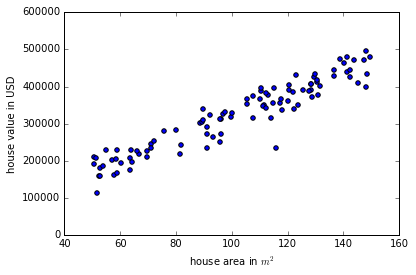

In [6]:
plt.scatter(d.area, d.value)
plt.xlabel("house area in $m^2$")
plt.ylabel("house value in USD")

**ASUMIMOS** que la relación entre el área ($y$) y el valor ($x_1$) es lineal, para la casa $i$:

$$y^{(i)} = \theta_0 + \theta_1 x_1^{(i)}$$

si establecemos que $x_0^{(i)}=1$ para todas las casas, entonces podemos escribir la expresión anterior de forma vectorial, con $\theta = [\theta_0, \theta_1]$ y $\mathbf{x}=[x_0, x_1]$

$$y^{(i)} = \theta\mathbf{x}^{(i)}$$

queremos encontrar los valores $\theta_{min}$ que parametrizan una recta de modo que

$$ J(\theta) =  \sum_{i=0}^{m-1} (\mathbf{x}\theta^{(i)}-y^{(i)})^2$$

$$\theta_{min} = \underset{\theta}{arg\,min} \,\,\,J(\theta)$$ 

en modo matricial

$$J(\theta) = sum(\mathbf{X}\theta-\mathbf{y})^2$$

P.ej., los parámetros $\theta_0=0$, $\theta_1=3800$ definen una recta que es mejorable respecto a los datos que tenemos. Observa como creamos las matrices $X$ e $y$, añadiendo una columna de unos a la matrix $X$

(100, 2) (100,)


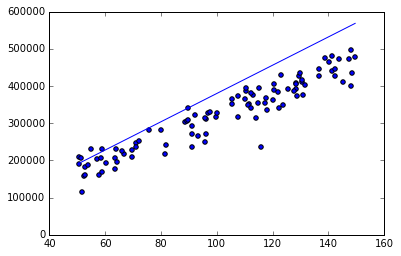

In [7]:
X = np.hstack((np.ones((len(d),1)), d[["area"]].as_matrix()))
y = d.value.as_matrix()
print X.shape, y.shape

t = np.array([0,3800])

xg = np.vstack((np.ones(100), np.linspace(np.min(d.area), np.max(d.area),100))).T
plt.scatter(d.area, d.value)
plt.plot(xg[:,1], xg.dot(t))

Una primera aproximación para obtener la recta con los parámetros $\theta_{min}$ según definido anteriormente es usando optimización _caja negra_. 

In [8]:
def cost(t):
    return np.sum((X.dot(t)-y)**2)

In [9]:
r = minimize(cost, [0,0], method="BFGS")
print r

      fun: 87173814841.43971
 hess_inv: array([[  6.22486109e-02,  -5.63373937e-04],
       [ -5.63373937e-04,   5.54403305e-06]])
      jac: array([    0., -4096.])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 135
      nit: 4
     njev: 31
   status: 2
  success: False
        x: array([ 24848.96670977,   2936.34079734])


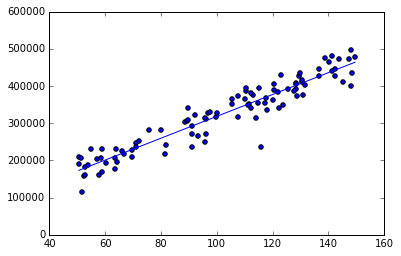

In [10]:
t = r.x
xg = np.vstack((np.ones(100), np.linspace(np.min(d.area), np.max(d.area),100))).T
plt.scatter(d.area, d.value)
plt.plot(xg[:,1], xg.dot(t))

El error de predicción medio que tenemos es de:

In [11]:
np.mean(np.abs(X.dot(t)-y))

El gradiente de $J$ es

$$\nabla J= 2X^{T}\cdot(X\cdot\theta-Y)$$

que podemos usar en los procesos de minimización

In [12]:
def grad(t):
    return 2*X.T.dot(X.dot(t)-y)

In [13]:
r = minimize(cost, [0,0], jac=grad, method="BFGS")
print r

      fun: 87173791346.97466
 hess_inv: array([[  6.23113465e-02,  -5.64148580e-04],
       [ -5.64148580e-04,   5.55323927e-06]])
      jac: array([  6.40284270e-10,  -1.00815415e-08])
  message: 'Optimization terminated successfully.'
     nfev: 6
      nit: 3
     njev: 6
   status: 0
  success: True
        x: array([ 24794.85968752,   2936.83230103])


también podemos obtener el gradiente usando sympy

In [14]:
import sympy
sympy.init_printing(use_latex=True)

In [76]:
t0,t1 = sympy.symbols("theta_0 theta_1")
t0,t1

fíjate en la expresión que obtenemos con un número reducido de datos y cómo la simplifica sympy

In [77]:
expr = 0
for i in range(10):
    expr += (X[i,0]*t0+X[i,1]*t1-y[i])**2
expr = expr/len(X)
expr

In [78]:
print y[:10]
X[:10]

[202970 312626 264921 272091 209846 317444 161472 478948 241927 350402]


array([[   1.  ,   57.02],
       [   1.  ,   96.07],
       [   1.  ,   93.18],
       [   1.  ,   91.05],
       [   1.  ,   69.76],
       [   1.  ,   99.59],
       [   1.  ,   57.62],
       [   1.  ,  149.57],
       [   1.  ,   81.67],
       [   1.  ,  111.62]])

In [79]:
expr = expr.simplify()
expr

obtenemos la expresion del coste para todos los datos y las derivadas parciales para el gradiente

In [46]:
expr_cost = 0
for i in range(len(X)):
    expr_cost += (X[i,0]*t0+X[i,1]*t1-y[i])**2
expr_cost = expr_cost.simplify()
expr_cost

In [47]:
expr_dt0 = expr_cost.diff(t0)
expr_dt1 = expr_cost.diff(t1)
expr_dt0, expr_dt1

y la función de coste y el jacobiano evaluable en Python

In [48]:
s_cost = sympy.lambdify([[t0,t1]], expr_cost, "numpy")

d0 = sympy.lambdify([[t0,t1]], expr_dt0, "numpy")
d1 = sympy.lambdify([[t0,t1]], expr_dt1, "numpy")
s_grad = lambda x: np.array([d0(x), d1(x)])

y ahora los usamos en el minimizador

In [50]:
r = minimize(s_cost, [0,0], jac=s_grad, method="BFGS")
print r

      fun: 87173791346.97119
 hess_inv: array([[  6.23113465e-02,  -5.64150650e-04],
       [ -5.64150650e-04,   5.55327713e-06]])
      jac: array([ -2.23517418e-08,   0.00000000e+00])
  message: 'Optimization terminated successfully.'
     nfev: 38
      nit: 4
     njev: 37
   status: 0
  success: True
        x: array([ 24794.85968752,   2936.83230103])


fíjate como las funciones son las mismas

In [73]:
t = np.array([np.random.random()*5000+20000, np.random.random()*1000+20000])
print "theta:",t
print "cost analytic:", cost(t)
print "cost symbolic:", s_cost(t)

print "gradient analytic:", grad(t)
print "gradient symbolic:", s_grad(t)

theta: [ 24359.01378228  20662.31165051]
cost analytic: 3.52476985235e+14
cost symbolic: 3.52476985235e+14
gradient analytic: [  3.60055930e+08   3.97696749e+10]
gradient symbolic: [  3.60055930e+08   3.97696749e+10]
